<a href="https://colab.research.google.com/github/larasauser/master/blob/main/NSPI_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Trouvé 6 dates communes


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


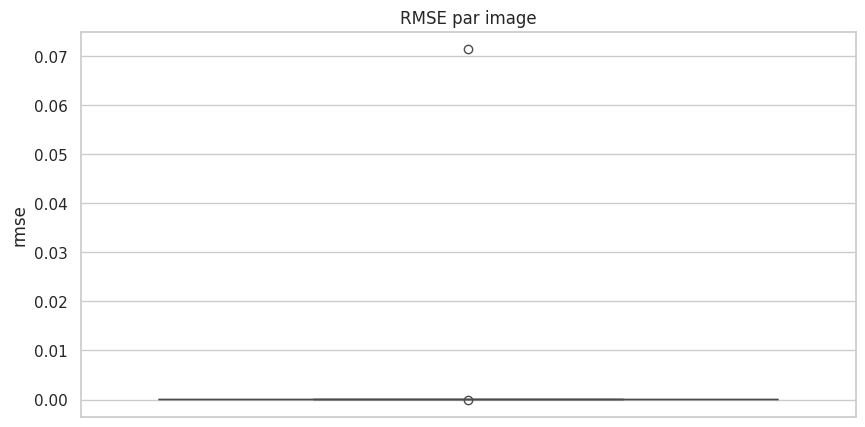

In [8]:
# ================================================================
# NSPI Gap-Fill Evaluator (Colab version complet + MS-SSIM + Graphiques)
# ================================================================
# 1) Monte ton Google Drive :
from google.colab import drive
drive.mount('/content/drive')
#
# 2) Modifie les chemins dans CONFIG ci-dessous
# ================================================================

!pip install rasterio scikit-image pandas numpy scipy torch piq seaborn --quiet

import os, re, math, glob
import numpy as np
import pandas as pd
import torch
import piq
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance, ks_2samp
from skimage.measure import label
from skimage.morphology import binary_erosion, disk
import rasterio

# --------------------------
# CONFIG (à modifier selon ton Drive)
# --------------------------
CONFIG = {
    "GT_DIR":   '/content/drive/MyDrive/NDVI_herens_Landsat8_10/imputed',            # ground truth
    "HOLE_DIR": "/content/drive/MyDrive/NDVI_herens_Landsat8_10/imputed/holes",      # images trouées
    "GAP_DIR":  "/content/drive/MyDrive/NDVI_herens_Landsat8_10/imputed/holes/filled_nspi2", # résultats NSPI
    "OUT_DIR":  "/content/drive/MyDrive/NDVI_herens_Landsat8_10/imputed/holes/filled_nspi2/NSPI_EVAL_OUT",

    "GT_GLOB": "*.tif",
    "HOLE_GLOB": "*.tif",
    "GAP_GLOB": "*.tif",

    "BORDER_WIDTH_PX": 3,
    "NDVI_BINS": [0.0, 0.2, 0.5, 0.8, 1.0],
    "SIZE_BINS": [0, 30, 80, 200, 10000],
    "SIZE_BINS_MODE": "fixed",  # ou "auto"

    "DATE_PATTERNS": [
        r"(?P<y>\d{4})[-_](?P<m>\d{2})[-_](?P<d>\d{2})",
        r"(?P<y>\d{4})(?P<m>\d{2})(?P<d>\d{2})",
        r"(?P<d>\d{2})[-_](?P<m>\d{2})[-_](?P<y>\d{4})",
    ],
    "NDVI_RANGE": [-1.0, 1.0],
    "RESPECT_RASTER_NODATA": True,
    "RANDOM_SEED": 42
}

# --------------------------
# Utilitaires
# --------------------------
def ensure_dir(path): os.makedirs(path, exist_ok=True)

def extract_date_token(filename, patterns):
    base = os.path.basename(filename)
    for pat in patterns:
        m = re.search(pat, base)
        if m:
            gd = m.groupdict()
            if {"y","m","d"} <= set(gd.keys()):
                return f"{int(gd['y']):04d}{int(gd['m']):02d}{int(gd['d']):02d}"
    m = re.search(r"(\d{8})", base)
    return m.group(1) if m else None

def load_raster(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
        nodata = src.nodata

        # Remplacer nodata par NaN
        if CONFIG["RESPECT_RASTER_NODATA"] and nodata is not None:
            arr = np.where(arr == nodata, np.nan, arr)

        # Conversion explicite des codes -9999 en NaN
        arr = np.where(arr == -9999, np.nan, arr)

    return arr

def gradient_magnitude(a):
    gy, gx = np.gradient(a)
    return np.sqrt(gx*gx + gy*gy)

def rmse(a,b): return float(np.sqrt(np.nanmean((a-b)**2)))
def mae(a,b):  return float(np.nanmean(np.abs(a-b)))
def bias(a,b): return float(np.nanmean(a-b))
def r2(a,b):
    ss_res = np.nansum((b-a)**2)
    ss_tot = np.nansum((b-np.nanmean(b))**2)
    return float(1-ss_res/ss_tot) if ss_tot>0 else np.nan

def psnr(a,b,data_range=2.0):
    mse = np.nanmean((a-b)**2)
    return float("inf") if mse<=0 else 20*math.log10(data_range)-10*math.log10(mse)

def ms_ssim_zero_filled(a, b, mask, data_range=2.0):
    a_fill, b_fill = a.copy(), b.copy()
    a_fill[~np.isfinite(a_fill)] = 0
    b_fill[~np.isfinite(b_fill)] = 0
    a_fill[~mask] = 0
    b_fill[~mask] = 0
    ta = torch.tensor(a_fill).unsqueeze(0).unsqueeze(0)
    tb = torch.tensor(b_fill).unsqueeze(0).unsqueeze(0)
    return float(piq.multi_scale_ssim(ta, tb, data_range=data_range).item())

def wasserstein_ndvi(a,b,mask):
    va,vb = a[mask], b[mask]
    va,vb = va[np.isfinite(va)], vb[np.isfinite(vb)]
    return float(wasserstein_distance(va,vb)) if va.size>0 and vb.size>0 else np.nan

def ks_test_ndvi(a,b,mask):
    va,vb = a[mask], b[mask]
    va,vb = va[np.isfinite(va)], vb[np.isfinite(vb)]
    return ks_2samp(va,vb) if va.size>0 and vb.size>0 else (np.nan,np.nan)

def make_border_core_masks(hole_mask, w):
    core = binary_erosion(hole_mask, disk(w)) if w>0 else np.zeros_like(hole_mask)
    border = hole_mask & ~core
    return border, core

def connected_components_sizes(hole_mask):
    lbl = label(hole_mask, connectivity=1)
    sizes = np.bincount(lbl.ravel())
    sizes = np.concatenate(([0], sizes[1:]))
    return sizes[lbl]

def compute_metrics(gt, pred, mask):
    valid = mask & np.isfinite(gt) & np.isfinite(pred)
    if valid.sum() == 0: return {}
    a,b = pred.copy(), gt.copy()
    a[~valid] = np.nan; b[~valid] = np.nan
    ks_stat, ks_p = ks_test_ndvi(a,b,valid)
    return {
        "n": int(valid.sum()),
        "rmse": rmse(a,b),
        "mae": mae(a,b),
        "bias": bias(a,b),
        "r2": r2(a,b),
        "psnr": psnr(a,b,2.0),
        "ms_ssim": ms_ssim_zero_filled(a,b,valid,2.0),
        "grad_l2": float(np.nanmean((gradient_magnitude(a)-gradient_magnitude(b))[valid]**2)**0.5),
        "emd": wasserstein_ndvi(a,b,valid),
        "ks_stat": ks_stat,
        "ks_p": ks_p
    }

# --------------------------
# Main
# --------------------------
ensure_dir(CONFIG["OUT_DIR"])
gt_files   = {extract_date_token(f,CONFIG["DATE_PATTERNS"]):f for f in glob.glob(os.path.join(CONFIG["GT_DIR"],CONFIG["GT_GLOB"]))}
hole_files = {extract_date_token(f,CONFIG["DATE_PATTERNS"]):f for f in glob.glob(os.path.join(CONFIG["HOLE_DIR"],CONFIG["HOLE_GLOB"]))}
gap_files  = {extract_date_token(f,CONFIG["DATE_PATTERNS"]):f for f in glob.glob(os.path.join(CONFIG["GAP_DIR"],CONFIG["GAP_GLOB"]))}

common = sorted(set(gt_files)&set(hole_files)&set(gap_files))
print(f"Trouvé {len(common)} dates communes")

pair_rows, group_rows = [], []
size_edges = np.array(CONFIG["SIZE_BINS"])
ndvi_edges = np.array(CONFIG["NDVI_BINS"])

for date in common:
    gt   = load_raster(gt_files[date])
    hole = load_raster(hole_files[date])
    pred = load_raster(gap_files[date])
    if gt.shape != pred.shape: continue
    hole_mask = (~np.isfinite(hole)) | (hole == -9999)
    if hole_mask.sum() == 0: continue

    gt_norm = (gt + 1) / 2
    pred_norm = (pred + 1) / 2
    m = compute_metrics(gt_norm, pred_norm, hole_mask)
    pair_rows.append({"date":date,"n_mask":int(hole_mask.sum()),**m})

    border_mask, core_mask = make_border_core_masks(hole_mask, CONFIG["BORDER_WIDTH_PX"])
    for name, mask in [("border",border_mask),("core",core_mask)]:
        if mask.sum()==0: continue
        m2 = compute_metrics(gt_norm, pred_norm, mask)
        group_rows.append({"date":date,"region":name,"n_mask":int(mask.sum()),**m2})

df_pair  = pd.DataFrame(pair_rows)
df_group = pd.DataFrame(group_rows)

df_pair.to_csv(os.path.join(CONFIG["OUT_DIR"],"metrics_pair.csv"),index=False)
df_group.to_csv(os.path.join(CONFIG["OUT_DIR"],"metrics_group.csv"),index=False)

# --------------------------
# Graphiques simples
# --------------------------
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df_pair,y="rmse")
ax.set_title("RMSE par image")
plt.show()


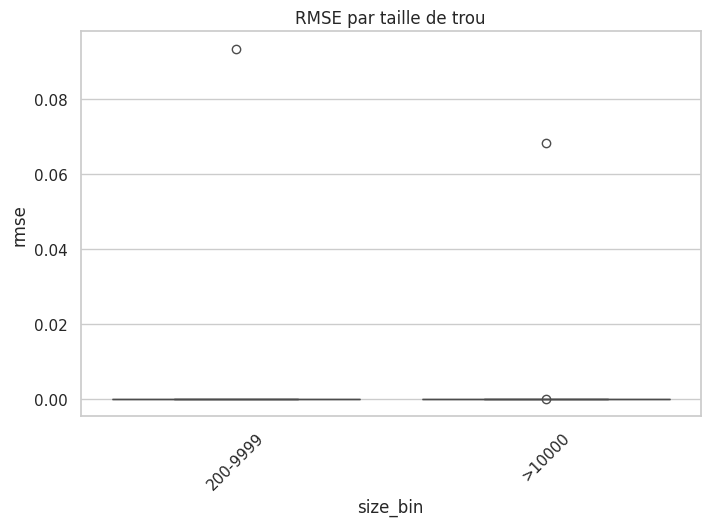

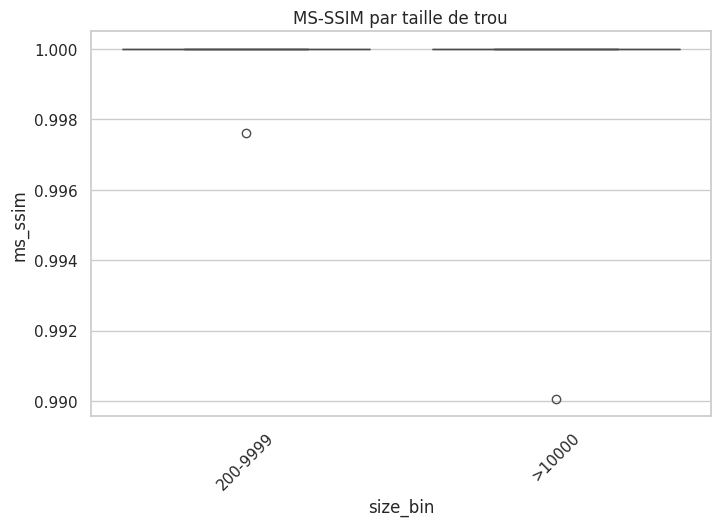

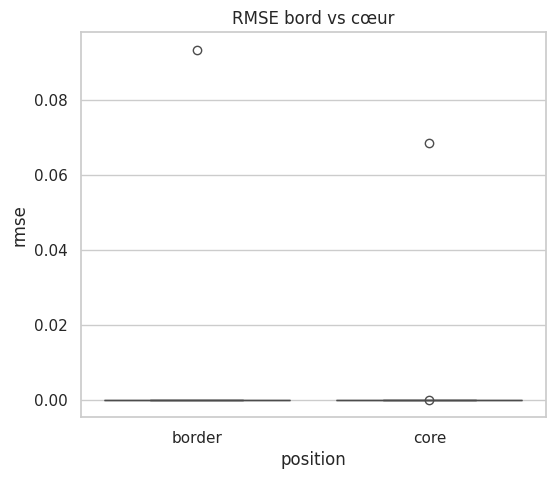

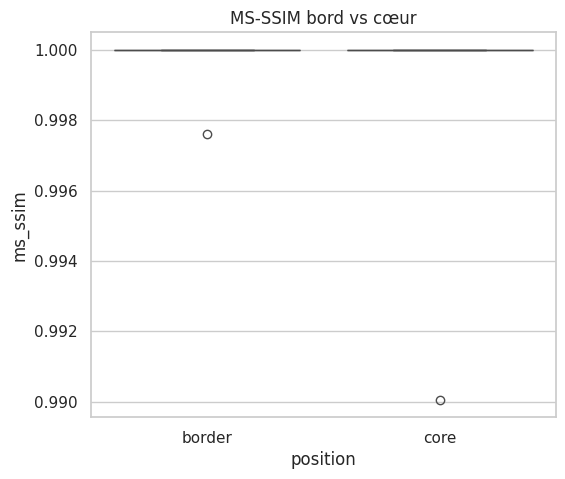

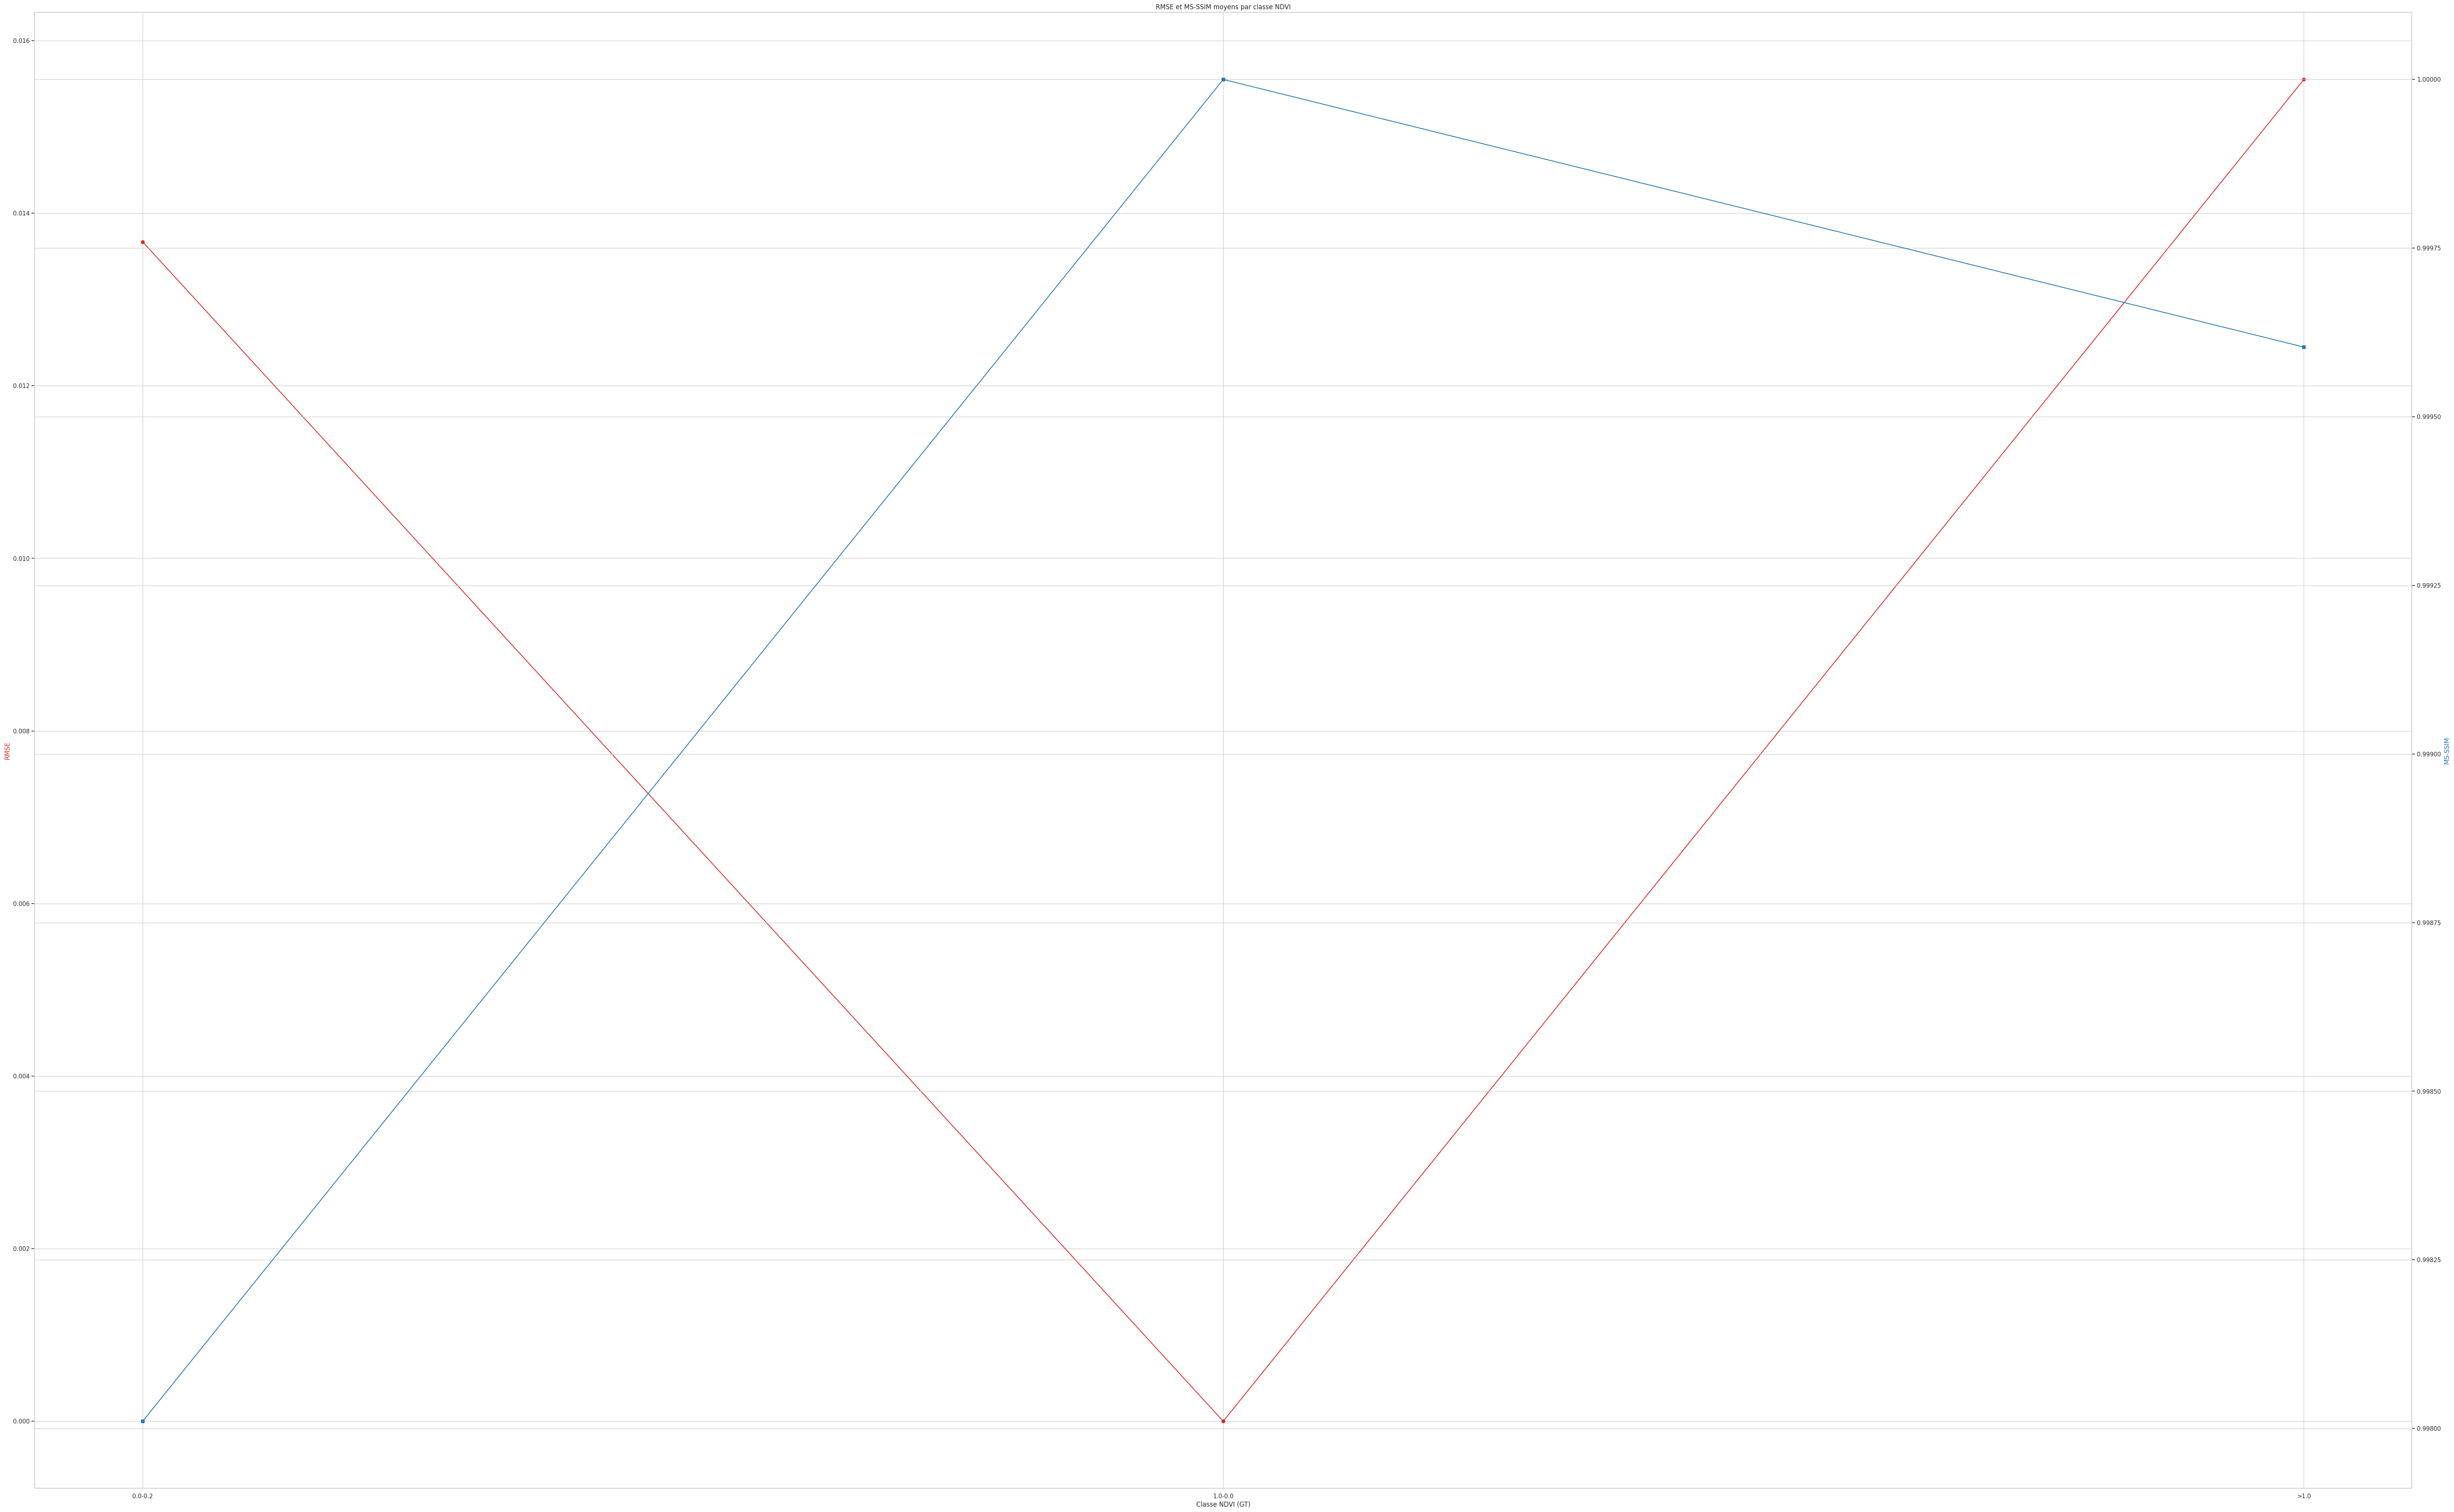

In [11]:
# --------------------------
# Visualisations détaillées
# --------------------------

# Ajout des colonnes de regroupement
df_group = df_group.copy()
df_group["position"] = df_group["region"]  # "border" ou "core"

# Taille des trous : bins selon CONFIG["SIZE_BINS"]
def assign_size_bin(row, size_edges):
    # On peut approx avec n_mask comme proxy de taille de trou
    idx = np.searchsorted(size_edges, row["n_mask"], side="right") - 1
    return f"{size_edges[idx]}-{size_edges[idx+1]-1}" if idx<len(size_edges)-1 else f">{size_edges[-1]}"

df_group["size_bin"] = df_group.apply(lambda r: assign_size_bin(r, np.array(CONFIG["SIZE_BINS"])), axis=1)

# NDVI moyen dans le trou (GT)
def assign_ndvi_bin(row, gt_file_dict, ndvi_edges):
    date = row["date"]
    gt_path = gt_files.get(date)
    if gt_path is None: return np.nan
    gt = load_raster(gt_path)
    mask = row["region"]=="core"
    val = np.nanmean(gt) if np.any(mask) else np.nan
    idx = np.searchsorted(ndvi_edges, val, side="right") - 1
    return f"{ndvi_edges[idx]}-{ndvi_edges[idx+1]}" if idx<len(ndvi_edges)-1 else f">{ndvi_edges[-1]}"

df_group["ndvi_bin"] = df_group.apply(lambda r: assign_ndvi_bin(r, gt_files, np.array(CONFIG["NDVI_BINS"])), axis=1)

# Séparation pour visualisation
df_size = df_group.copy()
df_pos  = df_group.copy()
df_ndvi = df_group.copy()
mean_ndvi = df_ndvi.groupby("ndvi_bin")[["rmse","ms_ssim"]].mean().reset_index()

# RMSE / MS-SSIM par taille
plt.figure(figsize=(8,5))
sns.boxplot(data=df_size, x="size_bin", y="rmse")
plt.title("RMSE par taille de trou")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=df_size, x="size_bin", y="ms_ssim")
plt.title("MS-SSIM par taille de trou")
plt.xticks(rotation=45)
plt.show()

# Bord vs cœur
plt.figure(figsize=(6,5))
sns.boxplot(data=df_pos, x="position", y="rmse")
plt.title("RMSE bord vs cœur")
plt.show()

plt.figure(figsize=(6,5))
sns.boxplot(data=df_pos, x="position", y="ms_ssim")
plt.title("MS-SSIM bord vs cœur")
plt.show()

# Moyennes par NDVI
fig, ax1 = plt.subplots(figsize=(80,50))
ax2 = ax1.twinx()
ax1.plot(mean_ndvi["ndvi_bin"], mean_ndvi["rmse"], marker="o", color="tab:red", label="RMSE")
ax2.plot(mean_ndvi["ndvi_bin"], mean_ndvi["ms_ssim"], marker="s", color="tab:blue", label="MS-SSIM")
ax1.set_xlabel("Classe NDVI (GT)")
ax1.set_ylabel("RMSE", color="tab:red")
ax2.set_ylabel("MS-SSIM", color="tab:blue")
plt.title("RMSE et MS-SSIM moyens par classe NDVI")
plt.xticks(rotation=45)
plt.show()
